In [74]:
 %load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [75]:
%autoreload 2

In [92]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import urllib
from bs4 import BeautifulSoup
import requests
from astropy.io import fits
from astropy.table import Table
import glob
import scipy.integrate
import scipy.stats
import scipy.interpolate
import scipy.optimize
import scipy.signal
import scipy.ndimage
import scipy.spatial
import seaborn as sns
#---------------- aux files ------------------------
import AuxFunctions as aux
from ProfileClass import PulsarProfile

# Auxilary functions

In [77]:
def is_float(value):
  try:
    float(value)
    return True
  except ValueError:
    return False

# ATNF Database

In [78]:
lines = []
with open('psrcat.db') as f:
    lines = f.readlines()
dict_list = []
tmp_dict = {}
for line in lines:
    if len(line,) == 0:
        print("ERROR: Zero length line")
        break
    if line[0] == '@':
        dict_list.append(tmp_dict)
        tmp_dict = {}
    else:
        splitted_line = line.split()
        if(is_float(splitted_line[1])):
            tmp_dict[splitted_line[0]] = float(splitted_line[1])
        else:
            tmp_dict[splitted_line[0]] = splitted_line[1]
data = pd.DataFrame(dict_list)
data.loc[data['F0'].notna(), 'P0'] = 1 / data['F0']
data.loc[data['P0'].notna(), 'F0'] = 1 / data['P0']
data.loc[data['F0'].notna() & data['F1'].notna(), 'P1'] = -data['F1'] / data['F0']**2 
data.loc[data['P0'].notna() & data['P1'].notna(), 'F1'] = -data['P1'] / data['P0']**2

data['B12'] = (data['P0'] * data['P1'] * 1e15)**0.5
data['AGE'] = data['P0'] / data['P1'] / 2
data['Q'] = data['P0']**(5/7) / (data['P1']*1e15)**(2/7)
data['L1400'] = data['S1400'] * data['DIST_DM']**2
data['L'] = 7.4e27 * data['L1400']
data['Edot'] = 3.95 * 1e31 * (data['P1'] / 1e-15)/ data['P0']**3
data['Eff'] = data['L'] / data['Edot']
data = data.set_index('PSRJ')

# Pulsars mean profiles database (.fits)

# FAST profiles

In [79]:
# ----downloading-----
# url = 'http://zmtt.bao.ac.cn/psr-fast/'
# reqs = requests.get(url)
# soup = BeautifulSoup(reqs.text, 'html.parser')
 
# urls = []
# for link in soup.find_all('a'):
#     link_string = link.get('href')
#     if link_string.split('/')[0] == 'whx23dat':
#         print(link_string.split('/')[1])
#         urllib.request.urlretrieve(url+link_string, 'FAST_profiles/' + link_string.split('/')[1])

In [80]:
data.loc['J1827+00'] = pd.Series({'P0': 0.375})
data.loc['J1934+09'] = pd.Series({'P0': 0.0046})
data.loc['J1826-00'] = pd.Series({'P0': 0.0045})
data.loc['J2041+46'] = pd.Series({'P0': 1.159})
data.loc['J1854-01'] = pd.Series({'P0': 0.680})
data.loc['J1849+0340g'] = pd.Series({'P0': 1.666})
data.loc['J1919+04'] = pd.Series({'P0': 0.0039})
data.loc['J1943+28'] = pd.Series({'P0': 0.737})
data.loc['J1944+16'] = pd.Series({'P0': 0.0024})
data.loc['J1852-0054g'] = pd.Series({'P0': 0.164})
data.loc['J1907+0555'] = pd.Series({'P0': 0.168})
data.loc['J1938+14A'] = pd.Series({'P0': 1.661})
data.loc['J1917+24'] = pd.Series({'P0': 0.0043})
data.loc['J1836+09'] = pd.Series({'P0': 0.541})
data.loc['J2021+24'] = pd.Series({'P0': 0.879})
data.loc['J1958+2213'] = pd.Series({'P0': 1.05})
data.loc['J1843+04'] = pd.Series({'P0': 0.397})
data.loc['J1858-02'] = pd.Series({'P0': 1.462})
data.loc['J2025+2133'] = pd.Series({'P0': 0.623})
data.loc['J1929+1905'] = pd.Series({'P0': 0.339})
data.loc['J0625+17'] = pd.Series({'P0': 2.518})
data.loc['J2108+41'] = pd.Series({'P0': 1.511})
data.loc['J1921+1540'] = pd.Series({'P0': 0.143})
data.loc['J2005+38'] = pd.Series({'P0': 2.461})




In [120]:
FASTfiles = glob.glob('FAST_Profiles/*')
FASTnames = []
for file in FASTfiles:
    name = file.split('/')[1]
    name = name.split('I')[0]
    name = name.replace('p', '+')
    name = name.replace('m', '-')
    FASTnames.append(name)
FASTProfiles = pd.DataFrame({'PSRJ': FASTnames, 'file_name': FASTfiles})
FASTProfiles = FASTProfiles.set_index('PSRJ')
FASTTable = pd.read_csv('KAT?.csv')
FASTTable.set_index('PSRJ', inplace=True)
FASTTable = FASTTable[~FASTTable.index.duplicated(keep='first')]
print(FASTTable)
FASTTable.rename(columns={'W10': 'W10_custom'}, inplace=True) #do not exist in Table!!!
FASTProfiles = FASTProfiles.merge(FASTTable, how='left', left_index=True, right_index=True)

            Mode
PSRJ            
J0011+08      Od
J0848+16     Od?
J1312+1810A   Od
J1538+2345    Od
J1641+3627A   Od
...          ...
J2129+1210A    ?
J2129+4119     ?
J2138+4911     ?
J2208+4056    Os
J2340+08       ?

[195 rows x 1 columns]


## MeerKAT profiles

In [105]:
MeerKATfiles = glob.glob('MeerKAT_Profiles/ar_files/*')
MeerKATnames = []
for file in MeerKATfiles:
    FASTnames.append(file.split('/')[2].split('_')[0])
FASTProfiles = pd.DataFrame({'PSRJ': FASTnames, 'file_name': FASTfiles})
MeerKATTable = pd.read_csv('MeerKat.csv')
MeerKATTable.set_index('PSRJ', inplace=True)
MeerKATTable.rename(columns={'W10': 'W10_custom'}, inplace=True)

MeerKATProfiles = MeerKATProfiles.set_index('PSRJ')
MeerKATProfiles = MeerKATProfiles.merge(MeerKATTable, how='left', left_index=True, right_index=True)

In [83]:
MeerKATTable1 = pd.read_csv('Census_Table1.csv')
MeerKATTable1.set_index('PSRJ', inplace=True)
data = pd.concat([MeerKATTable1['P'], data], axis=1)
data.loc[data['P0'].isna(), 'P0'] = data['P']
data = data.drop(columns=['P'])

In [163]:
MeerKATProfiles.loc['J1638-4725']
'J1638-4725' in MeerKATnames

True

In [84]:
data.loc['J0514-4407', 'P0']

0.3203

## EPN profiles

In [85]:
EPN_PSR_folders = glob.glob('EPN_ALL/fits/**/*')

In [86]:
EPNnames = []
for folder in EPN_PSR_folders:
    name = folder.split('/')[-1]
    if name[0] == 'B':
        name = data.index[data['PSRB'] == name][0]
    EPNnames.append(name)

# EPN_Profiles = pd.DataFrame({'PSRJ': EPNnames, 'EPNfolder': EPN_PSR_folders})
# EPN_Profiles = EPN_Profiles.set_index('PSRJ')

In [87]:
EPN_Profiles_dict = dict.fromkeys(EPNnames, [])
for i in range(len(EPN_PSR_folders)):
    folder = EPN_PSR_folders[i]
    files = glob.glob(folder+'/*')
    EPN_Profiles_dict[EPNnames[i]] = EPN_Profiles_dict[EPNnames[i]] + files #!!! do not use += 

# Useful subsets

## Fast and MeerKAT subsets

In [88]:
MeerKATsubset = data[data.index.isin(MeerKATnames)].copy()
FASTsubset = data[data.index.isin(FASTnames)].copy()

## FAST orthogonal subset

In [89]:
orthogonal_PSRs_FAST = []
for psr in FASTnames:
    profile = PulsarProfile(FASTProfiles.loc[psr]['file_name'], 'FAST')
    if profile.profile_type == 'orthogonal':
        orthogonal_PSRs_FAST.append(psr)
orthogonalFASTs = data[data.index.isin(orthogonal_PSRs_FAST)].copy()
print(np.sort(np.array(orthogonal_PSRs_FAST)))


['J0337+1715' 'J0653+4706' 'J0827+53' 'J1628+4406' 'J1630+3734'
 'J1710+4923' 'J1842+0358' 'J1849+0409' 'J1851+0118' 'J1851+0418'
 'J1852+0056g' 'J1853+1303' 'J1855+0700' 'J1857+0943' 'J1858-0024g'
 'J1909+0749' 'J1913+0832' 'J1913+1050' 'J1918+1541' 'J1921+0137'
 'J1926+0737' 'J1932+1059' 'J1934+2352' 'J1935+1726' 'J1935+2025'
 'J1939+2134' 'J1955+2908' 'J1959+2048' 'J2004+3429' 'J2023+5037'
 'J2032+4127' 'J2047+5029' 'J2053+4650' 'J2208+4056']


/Users/arseniy/Documents/Science/Physics/RadioPulsars/PulsarDataBase/ProfileClass.py:77: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


256
[0.25       0.74609375]
0.012392829969251373
10.828125
O
0.73046875 0.76171875


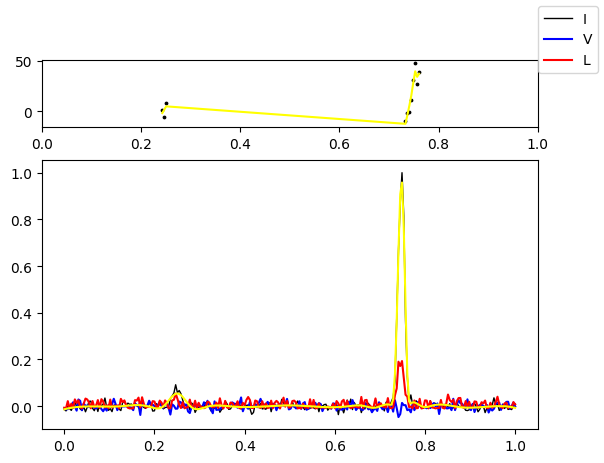

In [93]:
profile = PulsarProfile(FASTProfiles.loc['J1855+0700']['file_name'], 'FAST')
profile.plot_profile(plot_fit=True)
print(profile.Ncounts)
print(profile.find_peaks()/profile.Ncounts)
print(aux.noise_estimation(profile.I))
print(profile.get_Wa(10))
print(profile.get_mode())
print(profile.get_level_bounds(10)[0]/profile.Ncounts, profile.get_level_bounds(10)[1]/profile.Ncounts)

## MeerKAT orthogonal subset

In [94]:
orthogonal_PSRs_MeerKAT = []
for psr in MeerKATnames:
    if not psr in data.index:
        continue
    profile = PulsarProfile(MeerKATProfiles.loc[psr]['file_name'], 'MeerKAT')
    if profile.profile_type == 'orthogonal':
        # plt.plot(np.linspace(0, 1, pulsar_data[0].shape[0]), pulsar_data[0])
        orthogonal_PSRs_MeerKAT.append(psr)
orthogonalMeerKATs = data[data.index.isin(orthogonal_PSRs_MeerKAT)].copy()
print(np.sort(np.array(orthogonal_PSRs_MeerKAT)))
orthogonal_PSRs_MeerKAT += ['J1918+1541', 'J1851+0418', 'J1611-5209', 'J1828-1101', 'J0514-4407']


['J0514-4407' 'J0627+0706' 'J0835-3707' 'J0842-4851' 'J0905-5127'
 'J0908-4913' 'J1057-5226' 'J1126-6054' 'J1413-6307' 'J1549-4848'
 'J1637-4553' 'J1705-1906' 'J1722-3712' 'J1739-2903' 'J1755-0903'
 'J1816-0755' 'J1825-0935' 'J1842+0358' 'J1843-0702' 'J1849+0409'
 'J1909+0749' 'J1913+0832' 'J1926+0737' 'J1932+1059' 'J1935+2025']


In [95]:
orthogonal_PSRs_MeerKAT = list(set(orthogonal_PSRs_MeerKAT))

/Users/arseniy/Documents/Science/Physics/RadioPulsars/PulsarDataBase/ProfileClass.py:77: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


1024
1.3513162111587467
235.3359375
[0.04589844 0.70019531]
[0.09472656]
single


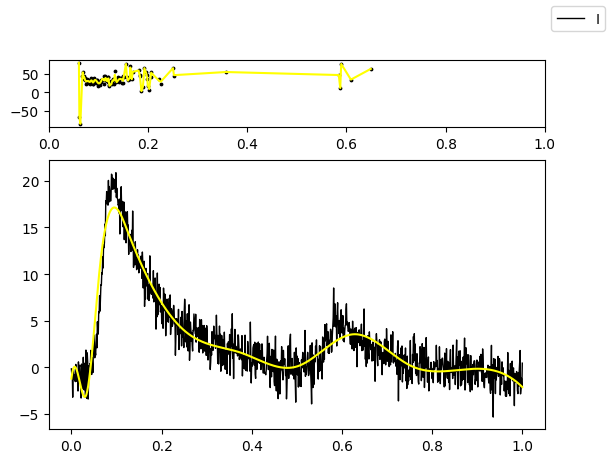

In [97]:
profile = PulsarProfile(MeerKATProfiles.loc['J1828-1101']['file_name'], 'MeerKAT')
profile.plot_profile(plot_fit=True, plot_pol=False)
print(profile.Ncounts)
print(aux.noise_estimation(profile.I))
print(profile.get_Wa(10))
print(np.array(profile.get_level_bounds(10))/profile.Ncounts)
print(profile.find_peaks()/profile.Ncounts)
print(profile.find_profile_type())

## Fast and MeerKAT manual mode subsets

In [122]:
MeerKATXs = MeerKATsubset.loc[MeerKATProfiles[(MeerKATProfiles['Mode'] == 'Xd') | (MeerKATProfiles['Mode'] == 'Xs')].index]
MeerKATOs = MeerKATsubset.loc[MeerKATProfiles[(MeerKATProfiles['Mode'] == 'Od') | (MeerKATProfiles['Mode'] == 'Os')].index]
FASTXs = FASTsubset.loc[FASTProfiles[(FASTProfiles['Mode'] == 'Xd') | (FASTProfiles['Mode'] == 'Xs')].index]
FASTOs = FASTsubset.loc[FASTProfiles[(FASTProfiles['Mode'] == 'Od') | (FASTProfiles['Mode'] == 'Os')].index]

# Profiles processing

# Space for working

# Width Statistics

In [169]:
def get_width_samples(ProfileDataBase, source, width=10, mode_info='external', sd_diff=False):
    Xs = []
    Xd = []
    Os = []
    Od = []
    for index, psr in ProfileDataBase.iterrows():
        pulsar_profile = PulsarProfile(psr['file_name'], source)
        if not (index in data.index):
            continue
        if data.loc[index]['P0'] < 0.03:
            continue
        if mode_info == 'external':
            if pulsar_profile.get_Wa(width) * data.loc[index]['P0']**0.5 < 60:
                reduced_width = pulsar_profile.get_Wa(width) * data.loc[index]['P0']**0.5
                if psr['Mode'] == 'Xs':
                    Xs.append(reduced_width)
                if psr['Mode'] == 'Xd':
                    Xd.append(reduced_width)
                if psr['Mode'] == 'Os':
                    Os.append(reduced_width)
                if psr['Mode'] == 'Od':
                    Od.append(reduced_width)
        elif mode_info == 'from_profile':
            if pulsar_profile.get_Wa(width) * data.loc[index]['P0']**0.5 < 60:
                reduced_width = pulsar_profile.get_Wa(width) * data.loc[index]['P0']**0.5
                if pulsar_profile.find_profile_type() == 'single':
                    mode = pulsar_profile.get_mode()
                    if mode == 'X':
                        Xs.append(reduced_width)
                    if mode == 'O':
                        Os.append(reduced_width)
                elif pulsar_profile.find_profile_type() == 'double':
                    mode = pulsar_profile.get_mode()
                    if mode == 'X':
                        Xd.append(reduced_width)
                    if mode == 'O':
                        Od.append(reduced_width)
    if sd_diff:
        return Xs, Xd, Os, Od
    else:
        return Xs + Xd, Os + Od

In [179]:
MeerKAT_XW10, MeerKAT_OW10 = get_width_samples(MeerKATProfiles, 'MeerKAT', mode_info='from_profile')
FAST_XW10, FAST_OW10 = get_width_samples(FASTProfiles, 'FAST', mode_info='from_profile')

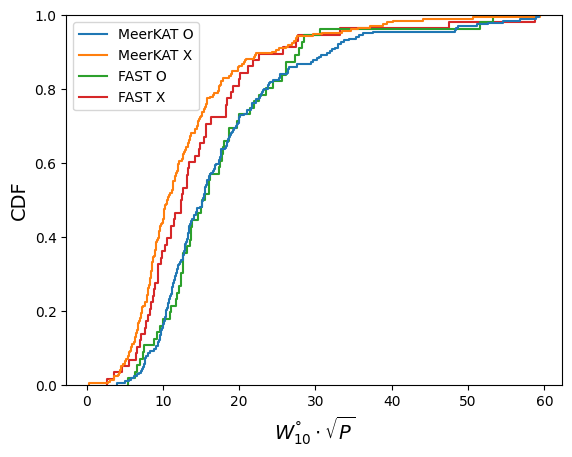

In [177]:
sns.ecdfplot({'MeerKAT O': MeerKAT_OW10, 'MeerKAT X':MeerKAT_XW10,'FAST O':FAST_OW10, 'FAST X':FAST_XW10}, palette='tab10')
plt.ylabel('CDF', fontsize=14)
plt.xlabel(r'$W_{10}^\degree \cdot \sqrt{P}$', fontsize=14)
plt.savefig('CDF_Both.png', dpi=400, bbox_inches='tight')


## Width statistics: FAST

In [184]:
XW10, OW10 = get_width_samples(FASTProfiles, 'FAST', mode_info='external', width=10)
XW50, OW50 = get_width_samples(FASTProfiles, 'FAST', mode_info='external', width=50)


In [185]:
def permutation_statistic(X, Y):
    n, m = len(X), len(Y)
    N = n + m
    sigmaX2, sigmaY2 = np.var(X), np.var(Y)
    return np.sqrt(N) * (np.mean(Y) - np.mean(X)) / np.sqrt(N / n * sigmaX2 + N / m * sigmaY2)

In [186]:
def permutation_statistic_median(X, Y):
    n, m = len(X), len(Y)
    N = n + m
    sigmaX2, sigmaY2 = scipy.stats.bootstrap((X,), np.median, method='percentile', n_resamples=100).standard_error**2, scipy.stats.bootstrap((Y,), np.median, method='percentile', n_resamples=100).standard_error**2
    return np.sqrt(N) * (np.median(Y) - np.median(X)) / np.sqrt(N / n * sigmaX2 + N / m * sigmaY2)

90.984375


/Users/arseniy/Documents/Science/Physics/RadioPulsars/PulsarDataBase/ProfileClass.py:77: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


'O'

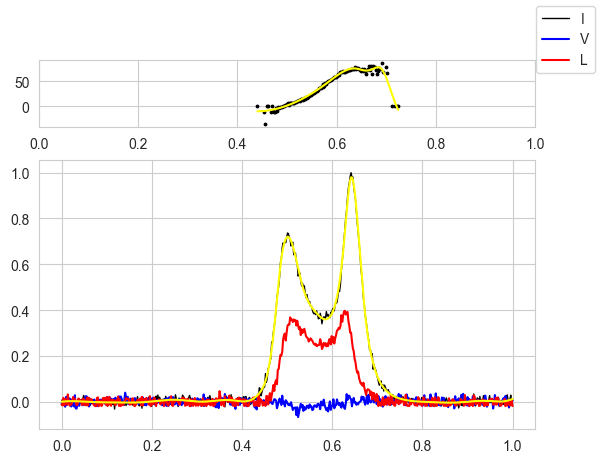

In [400]:
profile = PulsarProfile(FASTProfiles.loc['J2051+4434g']['FASTfile_name'], 'FAST')
print(profile.get_Wa(10) )
profile.plot_profile(plot_fit=True)
profile.get_mode()

In [187]:
# print(Nall, Ntrue, Ncomm, Ntrue / Ncomm)
print(len(XW50), len(OW50))

60 57


In [188]:
XW10 = np.sort(XW10)
OW10 = np.sort(OW10)
print(len(XW10), len(OW10))
NX = len(XW10)
NO = len(OW10)
print(np.median(XW10), XW10[int(0.5 * NX - 1.96 * 0.5 * np.sqrt(NX))], XW10[int(0.5 * NX + 1.96 * 0.5 * np.sqrt(NX))])
print(np.median(OW10), OW10[int(0.5 * NO - 1.96 * 0.5 * np.sqrt(NO))], OW10[int(0.5 * NO + 1.96 * 0.5 * np.sqrt(NO))])
print(np.mean(XW10), np.mean(OW10))
# print(scipy.stats.bootstrap((XW10,), np.median, method='percentile'))
# print(scipy.stats.bootstrap((XW10,), np.median, method='basic'))
# print(scipy.stats.bootstrap((OW10,), np.median, method='percentile'))
# print(scipy.stats.bootstrap((OW10,), np.median, method='basic'))

58 56
12.46373625487331 10.295246434994535 14.787082250118967
15.351219537350595 13.207232161659896 17.890560182216618
14.712283069564188 17.486796965441386


In [189]:
XW50 = np.sort(XW50)
OW50 = np.sort(OW50)
print(len(XW50), len(OW50))
NX = len(XW50)
NO = len(OW50)
print(np.median(XW50), XW10[int(0.5 * NX - 1.96 * 0.5 * np.sqrt(NX))], XW50[int(0.5 * NX + 1.96 * 0.5 * np.sqrt(NX))])
print(np.median(OW50), OW50[int(0.5 * NO - 1.96 * 0.5 * np.sqrt(NO))], OW50[int(0.5 * NO + 1.96 * 0.5 * np.sqrt(NO))])
print(np.mean(XW50), np.mean(OW50))

60 57
6.8675130930878385 10.592604512543097 8.536583567090563
8.11615683830371 7.079506841409796 10.161867547867036
8.391746120245694 9.197103223655702


KstestResult(statistic=0.2512315270935961, pvalue=0.042950942250736604, statistic_location=11.622524208293001, statistic_sign=1)
TtestResult(statistic=-1.553009000296322, pvalue=0.061621122828238444, df=112.0)
TtestResult(statistic=-1.5541191398753091, pvalue=0.061488675632429865, df=111.9972150539472)
Anderson_ksampResult(statistic=2.4440143470964206, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), pvalue=0.03228380723492673)
PermutationTestResult(statistic=2.887483282477284, pvalue=0.0243, null_distribution=array([-2.88317019, -0.279952  ,  1.8177975 , ..., -2.15481737,
        0.5883928 ,  0.52695163]))
PermutationTestResult(statistic=2.774513895877197, pvalue=0.0621, null_distribution=array([-1.08534915,  0.19175104,  1.71852665, ..., -2.96622251,
        2.42618672, -1.1802811 ]))


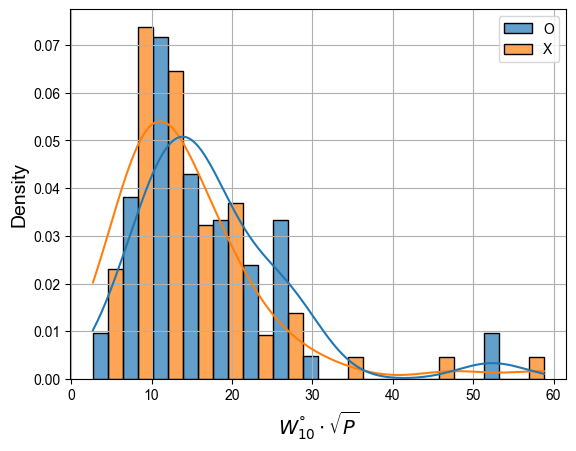

In [190]:
sns.histplot({'O': OW10, 'X':XW10}, kde=True, alpha=0.7, stat='density', palette='tab10', multiple="dodge", common_norm=False)
sns.set_style("whitegrid")
plt.grid(True)
# ax2 = plt.twinx()
# ax2.grid(False)
# sns.ecdfplot({'O': OW10, 'X':XW10}, alpha=0.7, palette='tab10', ax=ax2)
plt.ylabel('Density', fontsize=14)
plt.xlabel(r'$W_{10}^\degree \cdot \sqrt{P}$', fontsize=14)
print(scipy.stats.kstest(XW10, OW10))
print(scipy.stats.ttest_ind(XW10, OW10, alternative='less'))
print(scipy.stats.ttest_ind(XW10, OW10, equal_var=False, alternative='less'))
print(scipy.stats.anderson_ksamp([XW10, OW10]))
print(scipy.stats.permutation_test((XW10, OW10), lambda x, y: np.median(y) - np.median(x), alternative='greater'))
print(scipy.stats.permutation_test((XW10, OW10), lambda x, y: np.mean(y) - np.mean(x), alternative='greater'))
# print(scipy.stats.permutation_test((XW10, OW10), permutation_statistic, alternative='greater'))
# print(scipy.stats.permutation_test((XW10, OW10), permutation_statistic_median, alternative='greater'))



# plt.savefig('FAST_mode_comparison_manual.png', dpi=400, bbox_inches='tight')

KstestResult(statistic=0.1675438596491228, pvalue=0.33368387582215336, statistic_location=6.385817180852259, statistic_sign=1)
TtestResult(statistic=-0.7164953316108743, pvalue=0.2375690500156578, df=115.0)
TtestResult(statistic=-0.720796464112445, pvalue=0.23627263728082354, df=111.3529125697026)
Anderson_ksampResult(statistic=0.41774774033548234, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), pvalue=0.22407401858090722)
PermutationTestResult(statistic=1.2486437452158707, pvalue=0.1093, null_distribution=array([-2.05437362, -0.46196501, -1.04950445, ..., -0.96736478,
       -1.04964552, -1.24025849]))
PermutationTestResult(statistic=0.8053571034100084, pvalue=0.2363, null_distribution=array([ 1.22191365, -1.90895021, -0.18441047, ..., -1.04808267,
        3.05368328,  0.52498528]))


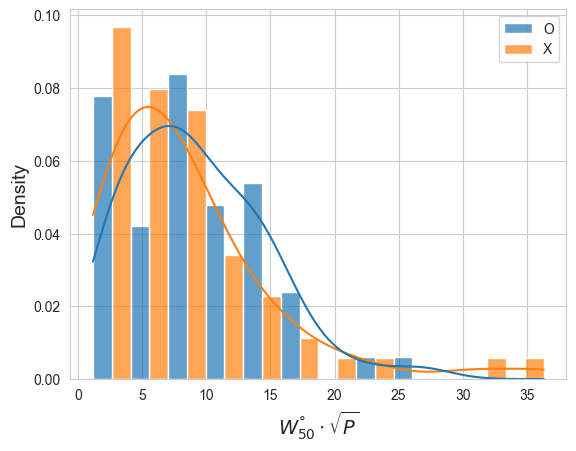

In [192]:
sns.histplot({'O': OW50, 'X':XW50}, kde=True, alpha=0.7, stat='density', palette='tab10', multiple="dodge", common_norm=False)
sns.set_style("whitegrid")
plt.grid(True)
plt.ylabel('Density', fontsize=14)
plt.xlabel(r'$W_{50}^\degree \cdot \sqrt{P}$', fontsize=14)
print(scipy.stats.kstest(XW50, OW50))
print(scipy.stats.ttest_ind(XW50, OW50, alternative='less'))
print(scipy.stats.ttest_ind(XW50, OW50, equal_var=False, alternative='less'))
print(scipy.stats.anderson_ksamp([XW50, OW50]))
print(scipy.stats.permutation_test((XW50, OW50), lambda x, y: np.median(y) - np.median(x), alternative='greater'))
print(scipy.stats.permutation_test((XW50, OW50), lambda x, y: np.mean(y) - np.mean(x), alternative='greater'))

Text(0.5, 0, '$W_{10}^\\degree \\cdot \\sqrt{P}$')

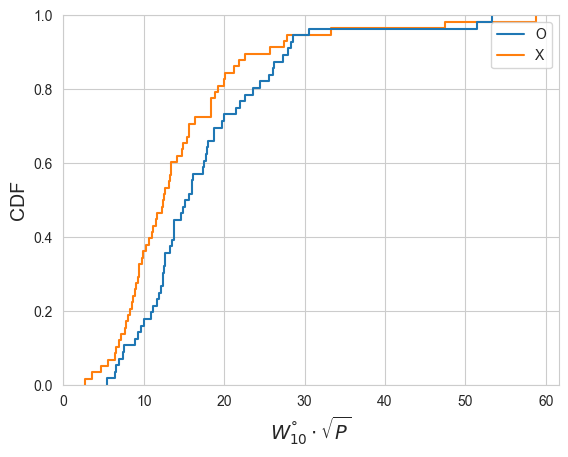

In [193]:
sns.ecdfplot({'O': OW10, 'X':XW10}, palette='tab10')
plt.ylabel('CDF', fontsize=14)
plt.xlabel(r'$W_{10}^\degree \cdot \sqrt{P}$', fontsize=14)
# plt.savefig('FAST_CDF_manual.png', dpi=400, bbox_inches='tight')

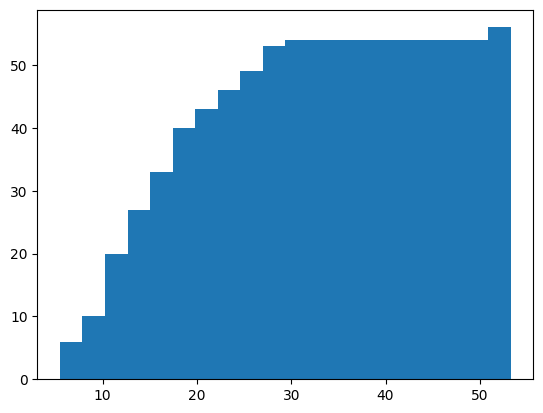

In [23]:
tmp = plt.hist(OW10, cumulative=True, bins=20)
vals = tmp[0]
widths = tmp[1][0:-1]

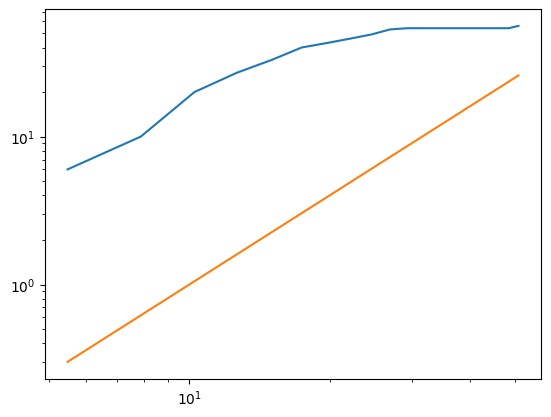

In [24]:
plt.plot(widths, vals)
plt.plot(widths, 0.01 * widths**2)
plt.xscale('log')
plt.yscale('log')

## Width statisticks MeerKAT

In [ ]:
XW10, OW10 = get_width_samples(MeerKATProfiles, 'MeerKAT', mode_info='external', width=10)
XW50, OW50 = get_width_samples(MeerKATProfiles, 'MeerKAT', mode_info='external', width=50)

In [27]:
# print(Nall, Ntrue, Ncomm, Ntrue / Ncomm)
XW10 = np.sort(XW10)
OW10 = np.sort(OW10)
print(len(XW10), len(OW10))
NX = len(XW10)
NO = len(OW10)
print(np.median(XW10), XW10[int(0.5 * NX - 1.96 * 0.5 * np.sqrt(NX))], XW10[int(0.5 * NX + 1.96 * 0.5 * np.sqrt(NX))])
print(np.median(OW10), OW10[int(0.5 * NO - 1.96 * 0.5 * np.sqrt(NO))], OW10[int(0.5 * NO + 1.96 * 0.5 * np.sqrt(NO))])
# print(scipy.stats.bootstrap((OW10,), np.median, method='percentile'))
# print(scipy.stats.bootstrap((OW10,), np.median, method='basic'))
# print(scipy.stats.bootstrap((OW10,), np.median, method='percentile'))


178 93
10.227388844355152 9.50282404905303 11.603682608048455
12.93419072831997 11.774312051549263 14.309100502382735


In [28]:
XW50 = np.sort(XW50)
OW50 = np.sort(OW50)
print(len(XW50), len(OW50))
NX = len(XW50)
NO = len(OW50)
print(np.median(XW50), XW50[int(0.5 * NX - 1.96 * 0.5 * np.sqrt(NX))], XW50[int(0.5 * NX + 1.96 * 0.5 * np.sqrt(NX))])
print(np.median(OW50), OW50[int(0.5 * NO - 1.96 * 0.5 * np.sqrt(NO))], OW50[int(0.5 * NO + 1.96 * 0.5 * np.sqrt(NO))])
print(scipy.stats.bootstrap((OW50,), np.median, method='percentile'))
print(scipy.stats.bootstrap((XW50,), np.median, method='percentile'))
print(scipy.stats.bootstrap((OW50,), np.median, method='basic'))
print(scipy.stats.bootstrap((XW50,), np.median, method='basic'))

183 97
4.903136051535809 4.313550204132016 5.508610001391739
7.0883574902854205 6.060980906573812 8.096070312173943
BootstrapResult(confidence_interval=ConfidenceInterval(low=6.060980906573812, high=7.966708548085591), bootstrap_distribution=array([7.49729941, 7.33635497, 7.20798974, ..., 8.09607031, 7.22638996,
       7.22638996]), standard_error=0.4286353730503003)
BootstrapResult(confidence_interval=ConfidenceInterval(low=4.313550204132016, high=5.535707010888488), bootstrap_distribution=array([4.86936441, 5.48828218, 5.19943779, ..., 5.19943779, 5.01866122,
       5.72702063]), standard_error=0.3094545949868388)
BootstrapResult(confidence_interval=ConfidenceInterval(low=6.080644668396898, high=8.115734073997029), bootstrap_distribution=array([7.63099503, 5.77394759, 7.22638996, ..., 7.30336185, 6.67900517,
       7.63099503]), standard_error=0.43637298333214875)
BootstrapResult(confidence_interval=ConfidenceInterval(low=4.2976621016798795, high=5.492721898939602), bootstrap_distrib

In [499]:
print(np.mean(XW10), np.mean(OW10), np.mean(XW50), np.mean(OW50))

13.280692091565598 16.849656376903326 6.1524143512976694 8.37182391250187


KstestResult(statistic=0.24030368047532596, pvalue=0.01790837006292804, statistic_location=9.50282404905303, statistic_sign=1)
TtestResult(statistic=-2.955471816751654, pvalue=0.0036131570941676547, df=154.0)
TtestResult(statistic=-2.900762546268768, pvalue=0.004364678887182424, df=131.5602266476665)
Anderson_ksampResult(statistic=4.478188162942034, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), pvalue=0.005365043052404834)
PermutationTestResult(statistic=3.4024390625533414, pvalue=0.0021, null_distribution=array([-0.34926706, -0.51204546, -2.53708112, ...,  0.69094879,
       -0.39656033,  0.23069671]))
PermutationTestResult(statistic=2.9200399235133214, pvalue=0.0015, null_distribution=array([-0.7089106 , -0.75858074,  1.98700834, ..., -0.73200778,
        0.46826385,  0.29108203]))


Text(0.5, 0, '$W_{10}^\\degree \\cdot \\sqrt{P}$')

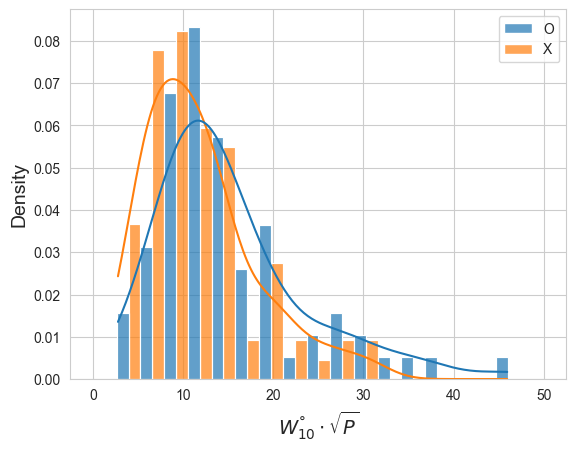

In [396]:
sns.histplot({'O': OW10, 'X':XW10}, kde=True, alpha=0.7, stat='density', palette="tab10", multiple="dodge", binrange=(0, 50), common_norm=False)
plt.ylabel('Density', fontsize=14)
print(scipy.stats.kstest(XW10, OW10))
print(scipy.stats.ttest_ind(XW10, OW10))
print(scipy.stats.ttest_ind(XW10, OW10, equal_var=False))
print(scipy.stats.anderson_ksamp([XW10, OW10]))
print(scipy.stats.permutation_test((XW10, OW10), lambda x, y: np.mean(y) - np.mean(x), alternative='greater'))
print(scipy.stats.permutation_test((XW10, OW10), permutation_statistic, alternative='greater'))
plt.xlabel(r'$W_{10}^\degree \cdot \sqrt{P}$', fontsize=14)
# plt.savefig('MeerKAT_mode_comparison_manual.png', dpi=400, bbox_inches='tight')

In [29]:
def fit_func(W, W0):
    a = W/W0
    return a**(-3) * scipy.integrate.quad_vec(lambda t: (1-t**2)**2 / (1 - a**-(2) * (1 - t**2))**0.5, -1, 1)[0]

KstestResult(statistic=0.2929412427468875, pvalue=2.6083942589238708e-05, statistic_location=5.103278066171528, statistic_sign=1)
TtestResult(statistic=-3.632724423223171, pvalue=0.000333899310899944, df=278.0)
TtestResult(statistic=-3.352830530032422, pvalue=0.001002352735156069, df=157.11189804709835)
Anderson_ksampResult(statistic=12.60570574697517, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), pvalue=0.001)


/var/folders/th/pqmsqtjd3nv8k0cddm4sm9mh0000gn/T/ipykernel_69638/1367474162.py:10: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  print(scipy.stats.anderson_ksamp([XW50, OW50]))


PermutationTestResult(statistic=2.219409561204201, pvalue=0.0004, null_distribution=array([-0.02131534, -1.01615416,  0.97320989, ..., -0.1497052 ,
       -0.0571925 ,  0.10396693]))


Text(0.5, 0, '$W_{50}^\\degree \\cdot \\sqrt{P}$')

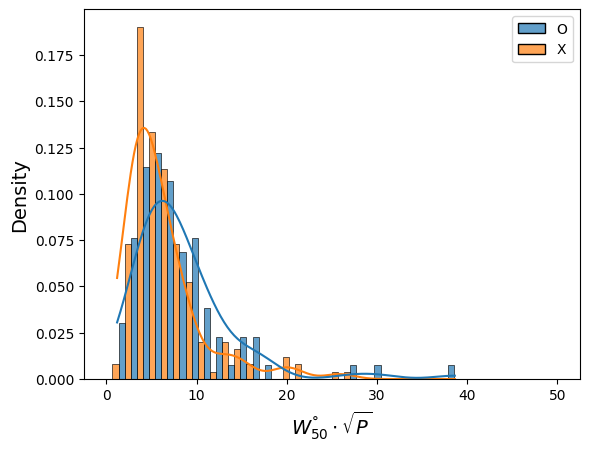

In [30]:
# W0 = 5
# Ws = np.linspace(1.1 * W0, 40, 100)
# plt.plot(Ws, 1e-1 * fit_func(Ws, 8), c='r')
sns.histplot({'O': OW50, 'X':XW50}, kde=True, alpha=0.7, stat='density', palette="tab10", multiple="dodge", binrange=(0, 50), common_norm=False)
plt.plot()
plt.ylabel('Density', fontsize=14)
print(scipy.stats.kstest(XW50, OW50))
print(scipy.stats.ttest_ind(XW50, OW50))
print(scipy.stats.ttest_ind(XW50, OW50, equal_var=False))
print(scipy.stats.anderson_ksamp([XW50, OW50]))
print(scipy.stats.permutation_test((XW50, OW50), lambda x, y: np.mean(y) - np.mean(x), alternative='greater'))
# print(scipy.stats.permutation_test((XW10, OW10), permutation_statistic, alternative='greater'))
plt.xlabel(r'$W_{50}^\degree \cdot \sqrt{P}$', fontsize=14)

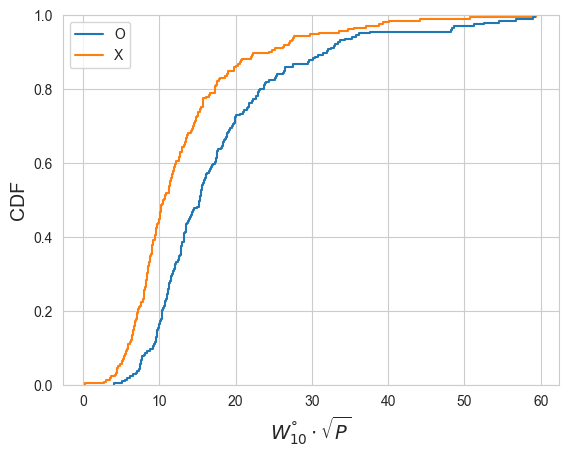

In [ ]:
sns.ecdfplot({'O': OW10, 'X':XW10}, palette='tab10')
plt.ylabel('CDF', fontsize=14)
plt.xlabel(r'$W_{10}^\degree \cdot \sqrt{P}$', fontsize=14)
# plt.savefig('MeerKAT_CDF_manual.png', dpi=400, bbox_inches='tight')

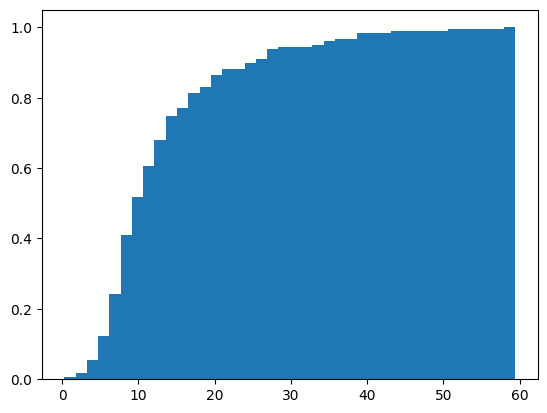

In [31]:
tmp = plt.hist(XW10, cumulative=True, bins=40, density=True)
vals = tmp[0]
widths = tmp[1][0:-1]

[ 5.44290319 10.         -1.6419875 ]


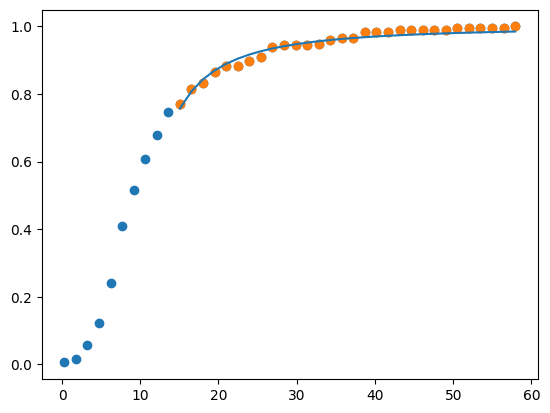

In [40]:
plt.scatter(widths, vals)
plt.scatter(widths[10:], vals[10:])
def fit_power_law(t, t0, a, degree):
    return 1-a * (t - t0)**(degree)
popt, pcov = scipy.optimize.curve_fit(fit_power_law, widths[10:], vals[10:], bounds=((0, 0, -5), (10, 10, 0)))
print(popt)
plt.plot(widths[10:], fit_power_law(widths[10:], *popt))
# plt.xscale('log')
# plt.yscale('log')

[0.00352217 2.31385009]


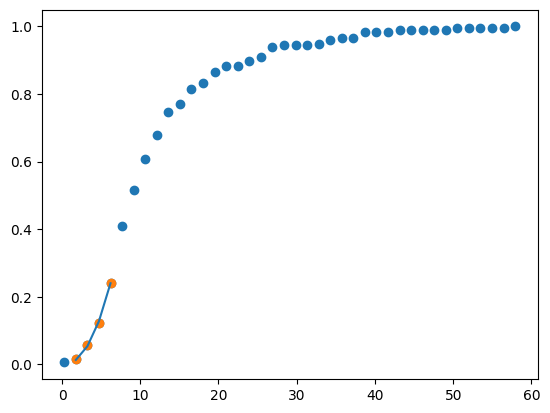

In [71]:
plt.scatter(widths, vals)
plt.scatter(widths[1:5], vals[1:5])
def fit_power_law2(t, a, degree):
    return a * t**(degree)
popt, pcov = scipy.optimize.curve_fit(fit_power_law2, widths[1:5], vals[1:5], bounds=((0, 0), (10, 5)))
print(popt)
plt.plot(widths[1:5], fit_power_law2(widths[1:5], *popt))
# plt.xscale('log')
# plt.yscale('log')

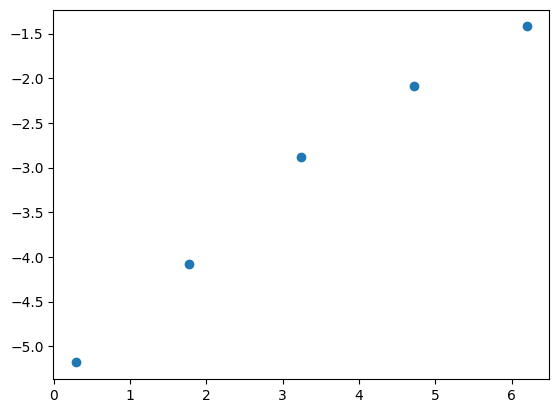

In [73]:
plt.scatter(widths[:5], np.log(vals[:5]))

ValueError: x and y must be the same size

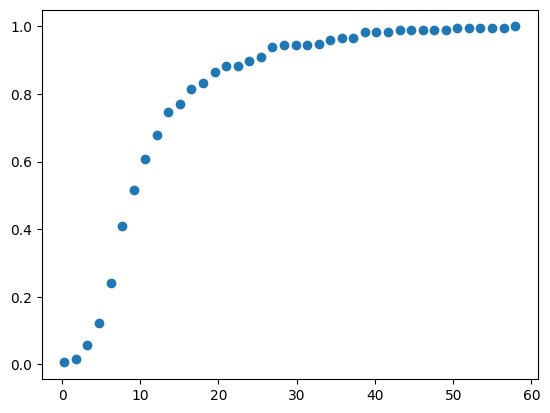

In [64]:
plt.scatter(widths, vals)
plt.scatter(widths[10:], vals[10:])
def fit_exp(t, t0, a):
    return a * np.exp(-(t - t0))
popt, pcov = scipy.optimize.curve_fit(fit_exp, widths[10:], vals[10:], bounds=((0, 0), (18, 1)))
print(popt)
plt.plot(widths[10:], fit_exp(widths[10:], 10, 0.8))
plt.xscale('log')
plt.yscale('log')

In [ ]:
profile = PulsarProfile(data.loc['J1921+1419']['FASTfile_name'], 'FAST')
profile.plot_profile(plot_fit=True)
print(profile.find_peaks()/profile.Ncounts)
print(profile.get_Wa(10))
print(profile.get_mode())
print(profile.get_level_bounds(10)[0]/profile.Ncounts, profile.get_level_bounds(10)[1]/profile.Ncounts)


In [ ]:
profile = PulsarProfile(data.loc['J1525-5417']['MeerKATfile_name'], 'MeerKAT')
profile.plot_profile(plot_fit=True)
print(profile.find_peaks()/profile.Ncounts)
print(profile.get_Wa(10))
print(profile.get_mode())
print(profile.get_level_bounds(10)[0]/profile.Ncounts, profile.get_level_bounds(10)[1]/profile.Ncounts)



# To plot

In [ ]:
profile_data = read_profile_data(FASTProfiles.loc['J1851+0118']['FASTfile_name'], 'FAST')
print(find_profile_type(profile_data[0]))
# profile_data[0] = scipy.ndimage.gaussian_filter1d(profile_data[0], profile_data[0].shape[0] // 500 + 1, mode='nearest')
phase = np.linspace(-0.5, 0.5, profile_data[0].shape[0])
noise = noise_estimation(profile_data[0])
spl = scipy.interpolate.splrep(phase, profile_data[0], s=profile_data[0].shape[0]*noise**2)
I_func = scipy.interpolate.BSpline(*spl)
plt.plot(phase, profile_data[0])
plt.plot(phase, profile_data[1])
plt.plot(phase, profile_data[2])
plt.plot(phase, I_func(phase))
peaks = find_peaks_number(profile_data[0])
# # print(find_peaks_number(I_func(phase)))
# # peaks, info = scipy.signal.find_peaks(I_func(phase), prominence=np.max(profile_data[0] * 0.05), height=4 * noise)
# print(noise_estimation(profile_data[0])*4)
for peak in peaks:
    plt.axvline(phase[peak], c='r')

## Mean angles estimation

In [ ]:
MeerKATsubset = data[data.index.isin(MeerKATnames)].copy()
FASTsubset = data[data.index.isin(FASTnames)].copy()
print(MeerKATsubset[MeerKATsubset['P0'] <= 0.033].shape)
print(MeerKATsubset[(MeerKATsubset['P0'] > 0.033) & (MeerKATsubset['P0'] <= 0.5)].shape)
print(MeerKATsubset[(MeerKATsubset['P0'] > 0.5) & (MeerKATsubset['P0'] <= 1.0)].shape)
print(MeerKATsubset[MeerKATsubset['P0'] > 1.0].shape)

In [ ]:
MeerKATsubset['CHI'] = np.arcsin(5 * MeerKATsubset['P0']**(-0.5) / MeerKATsubset['W50']) * 180 / np.pi
FASTsubset['CHI'] = np.arcsin(5 * FASTsubset['P0']**(-0.5) / FASTsubset['W50']) * 180 / np.pi


In [ ]:
Ps = np.arange(0, 2.1, 0.5)

av_chis = np.zeros(Ps.shape[0]-1)
av_chisXs = np.zeros(Ps.shape[0]-1)
av_chisOs = np.zeros(Ps.shape[0]-1)
Ns_all = np.zeros(Ps.shape[0]-1)
Ns_Os = np.zeros(Ps.shape[0]-1)
Ns_Xs = np.zeros(Ps.shape[0]-1)

for i in range(Ps.shape[0]-1):
    av_chisXs[i] = MeerKATXs[(MeerKATXs['P0'] >= Ps[i]) & (MeerKATXs['P0'] < Ps[i+1])]['CHI'].mean()
    Ns_Xs[i] =  MeerKATXs[(MeerKATXs['P0'] >= Ps[i]) & (MeerKATXs['P0'] < Ps[i+1])].count()['CHI']
    av_chisOs[i] = MeerKATOs[(MeerKATOs['P0'] >= Ps[i]) & (MeerKATOs['P0'] < Ps[i+1])]['CHI'].mean()
    Ns_Os[i] =  MeerKATOs[(MeerKATOs['P0'] >= Ps[i]) & (MeerKATOs['P0'] < Ps[i+1])].count()['CHI']
    av_chis[i] = MeerKATsubset[(MeerKATsubset['P0'] >= Ps[i]) & (MeerKATsubset['P0'] < Ps[i+1])]['CHI'].mean()
    Ns_all[i] = MeerKATsubset[(MeerKATsubset['P0'] >= Ps[i]) & (MeerKATsubset['P0'] < Ps[i+1])].count()['CHI']
    
    

In [ ]:
plt.errorbar(Ps[:-1], av_chis, 15/np.sqrt(Ns_all), c='orange', label='All', fmt='o', capsize=3)
plt.errorbar(Ps[:-1], av_chisXs, 15/np.sqrt(Ns_Xs), c='blue', label='X', fmt='o', capsize=3)
plt.errorbar(Ps[:-1], av_chisOs, 15/np.sqrt(Ns_Os), c='green', label='O', fmt='o', capsize=3)

plt.xlabel('P', size=14)
plt.ylabel(r'$<\chi>$', size=14)
plt.title('MeerKAT', size=18)
plt.legend()
plt.savefig('MeerKAT_mean_angles.png', dpi=400)

In [ ]:
Ps = np.arange(0, 2.1, 0.5)

av_chis = np.zeros(Ps.shape[0]-1)
av_chisXs = np.zeros(Ps.shape[0]-1)
av_chisOs = np.zeros(Ps.shape[0]-1)
Ns_all = np.zeros(Ps.shape[0]-1)
Ns_Os = np.zeros(Ps.shape[0]-1)
Ns_Xs = np.zeros(Ps.shape[0]-1)

for i in range(Ps.shape[0]-1):
    av_chisXs[i] = FASTXs[(FASTXs['P0'] >= Ps[i]) & (FASTXs['P0'] < Ps[i+1])]['CHI'].mean()
    Ns_Xs[i] =  FASTXs[(FASTXs['P0'] >= Ps[i]) & (FASTXs['P0'] < Ps[i+1])].count()['CHI']
    av_chisOs[i] = FASTOs[(FASTOs['P0'] >= Ps[i]) & (FASTOs['P0'] < Ps[i+1])]['CHI'].mean()
    Ns_Os[i] =  FASTOs[(FASTOs['P0'] >= Ps[i]) & (FASTOs['P0'] < Ps[i+1])].count()['CHI']
    av_chis[i] = FASTsubset[(FASTsubset['P0'] >= Ps[i]) & (FASTsubset['P0'] < Ps[i+1])]['CHI'].mean()
    Ns_all[i] = FASTsubset[(FASTsubset['P0'] >= Ps[i]) & (FASTsubset['P0'] < Ps[i+1])].count()['CHI']
    
    

In [ ]:
plt.errorbar(Ps[:-1], av_chisXs, 15/np.sqrt(Ns_Xs), c='blue', label='X', fmt='o', capsize=3)
plt.errorbar(Ps[:-1], av_chisOs, 15/np.sqrt(Ns_Os), c='green', label='O', fmt='o', capsize=3)
plt.errorbar(Ps[:-1], av_chis, 15/np.sqrt(Ns_all), c='orange', label='All', fmt='o', capsize=3)

plt.xlabel('P', size=14)
plt.ylabel(r'$<\chi>$', size=14)
plt.title('FAST', size=18)
plt.legend()
plt.savefig('FAST_mean_angles.png', dpi=400)

## Orthogonals analysis

In [409]:
MeerKATsubset = data[data.index.isin(MeerKATnames)].copy()
orthogonalMeerKATs = data[data.index.isin(orthogonal_PSRs_MeerKAT)].copy()
FASTsubset = data[data.index.isin(FASTnames)].copy()
orthogonalFASTs = data[data.index.isin(orthogonal_PSRs_FAST)].copy()

In [412]:
print(len(orthogonalMeerKATs[(orthogonalMeerKATs['P0'] < 0.03)]))
print(len(orthogonalMeerKATs[(orthogonalMeerKATs['P0'] > 0.03) & (orthogonalMeerKATs['P0'] < 0.1)]))
print(len(orthogonalMeerKATs[(orthogonalMeerKATs['P0'] > 0.1) & (orthogonalMeerKATs['P0'] < 0.2)]))
print(len(orthogonalMeerKATs[(orthogonalMeerKATs['P0'] > 0.2) & (orthogonalMeerKATs['P0'] < 0.3)]))
print(len(orthogonalMeerKATs[(orthogonalMeerKATs['P0'] > 0.3) & (orthogonalMeerKATs['P0'] < 0.4)]))
print(len(orthogonalMeerKATs[(orthogonalMeerKATs['P0'] > 0.4) & (orthogonalMeerKATs['P0'] < 0.5)]))
print(len(orthogonalMeerKATs[(orthogonalMeerKATs['P0'] > 0.5)]))

0
2
7
9
6
1
4


In [413]:
print(len(orthogonalFASTs[(orthogonalFASTs['P0'] < 0.03)]))
print(len(orthogonalFASTs[(orthogonalFASTs['P0'] > 0.03) & (orthogonalFASTs['P0'] < 0.1)]))
print(len(orthogonalFASTs[(orthogonalFASTs['P0'] > 0.1) & (orthogonalFASTs['P0'] < 0.2)]))
print(len(orthogonalFASTs[(orthogonalFASTs['P0'] > 0.2) & (orthogonalFASTs['P0'] < 0.3)]))
print(len(orthogonalFASTs[(orthogonalFASTs['P0'] > 0.3) & (orthogonalFASTs['P0'] < 0.4)]))
print(len(orthogonalFASTs[(orthogonalFASTs['P0'] > 0.4) & (orthogonalFASTs['P0'] < 0.5)]))
print(len(orthogonalFASTs[(orthogonalFASTs['P0'] > 0.5)]))

13
1
5
6
3
2
4


In [452]:
P1 = 0.033
P2 = 0.5
print('MeerKAT')
print(len(orthogonalMeerKATs[(orthogonalMeerKATs['P0'] > P1) & (orthogonalMeerKATs['P0'] < P2)]) / (len(MeerKATsubset[(MeerKATsubset['P0'] > P1) & (MeerKATsubset['P0'] < P2)]))*100)
print(len(orthogonalMeerKATs[(orthogonalMeerKATs['P0'] > P1) & (orthogonalMeerKATs['P0'] < P2)]))
print((len(MeerKATsubset[(MeerKATsubset['P0'] > P1) & (MeerKATsubset['P0'] < P2)])))
print('FAST')
print(len(orthogonalFASTs[(orthogonalFASTs['P0'] > P1) & (orthogonalFASTs['P0'] < P2)]) / (len(FASTsubset[(FASTsubset['P0'] > P1) & (FASTsubset['P0'] < P2)]))*100)
print(len(orthogonalFASTs[(orthogonalFASTs['P0'] > P1) & (orthogonalFASTs['P0'] < P2)]))
print(len(FASTsubset[(FASTsubset['P0'] > P1) & (FASTsubset['P0'] < P2)]))


MeerKAT
3.5593220338983054
21
590
FAST
7.296137339055794
17
233


In [ ]:
MeerKATdivs = []
for psr in orthogonal_PSRs_MeerKAT:
    profile = PulsarProfile(MeerKATProfiles.loc[psr]['MeerKATfile_name'], 'MeerKAT')
    peaks = profile.find_peaks()
    MeerKATdivs.append(np.min(peaks) / np.max(peaks))


In [ ]:
FASTdivs = []
for psr in orthogonal_PSRs_FAST:
    profile = PulsarProfile(FASTProfiles.loc[psr]['FASTfile_name'], 'FAST')
    peaks = profile.find_peaks()
    FASTdivs.append(np.min(peaks) / np.max(peaks))


In [ ]:
print(f'FAST median = {np.median(FASTdivs)}, MeerKAT median = {np.median(MeerKATdivs)}')

In [ ]:
plt.hist(FASTdivs)
plt.hist(MeerKATdivs)

In [ ]:
import DataLoaders

In [ ]:
test_profile = DataLoaders.load_MeerKAT_mean_data(data.loc['J0835-3707']['MeerKATfile_name'])

In [ ]:
# plt.plot(test_profile[0])
fft_vals = scipy.fft.fft(test_profile[0])